In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:


data = pd.read_csv("data/orders_and_shipments.csv")

data.columns = data.columns.str.strip()

data["Shipment Date"] = data["Shipment Year"].astype(str) + "-" + data["Shipment Month"].astype(str) + "-" + data["Shipment Day"].astype(str)

data["Shipment Date"] = pd.to_datetime(data["Shipment Date"])

data["Order Date"] = data["Order Year"].astype(str) + "-" + data["Order Month"].astype(str) + "-" + data["Order Day"].astype(str) + "-" + data["Order Time"]

data["Order Date"] = pd.to_datetime(data["Order Date"])

data["Shipment Days - Actual"] = np.ceil(( data["Shipment Date"]  - data["Order Date"]) / np.timedelta64(1, 'D')) # round up

data["Late Shipment"] = (data["Shipment Days - Scheduled"] - data["Shipment Days - Actual"]) < 0

data["Shipment Days - Late"] = data["Shipment Days - Actual"] - data["Shipment Days - Scheduled"]
data["Shipment Days - Late"][data["Late Shipment"] == False] = 0 
# some orders got shipped before order date maybe data entry error in order date or shipment date, this analysis consider these observation as not being late



In [3]:

quantity_demanded = data.groupby(["Order YearMonth", "Product Name"])["Order Quantity"].sum().reset_index()

on_time_rate = data.groupby(["Order YearMonth", "Product Name"])["Late Shipment"].apply(lambda x: 1- (x.sum() / x.count())).reset_index()
on_time_rate.rename({"Late Shipment": "On time shipment rate"}, axis = 1, inplace = True)


In [4]:
inventory = pd.read_csv("data/inventory.csv")
inventory.head()
inventory.columns = inventory.columns.str.strip()

inventory = pd.merge(inventory, quantity_demanded, left_on=["Product Name", "Year Month"], right_on=["Product Name", "Order YearMonth"]).drop(["Order YearMonth"], axis = 1)

inventory = pd.merge(inventory, on_time_rate, left_on=["Product Name", "Year Month"], right_on=["Product Name", "Order YearMonth"]).drop(["Order YearMonth"], axis = 1)

inventory["Under Stock"] = (inventory["Order Quantity"] - inventory["Warehouse Inventory"]) > 0
inventory["Year Month"] = inventory["Year Month"].astype(str)
inventory["Year Month"] = pd.to_datetime(inventory["Year Month"].str[0:4] + "-" + inventory["Year Month"].str[-2:])

In [5]:
fulfillment = pd.read_csv("data/fulfillment.csv")
fulfillment.head()


,Product Name,Warehouse Order Fulfillment (days)
0,Perfect Fitness Perfect Rip Deck,8.3
1,Nike Men's Dri-FIT Victory Golf Polo,6.6
2,O'Brien Men's Neoprene Life Vest,5.5
3,Nike Men's Free 5.0+ Running Shoe,9.4
4,Under Armour Girls' Toddler Spine Surge Runni,6.3


# Just In Time supply chain analysis

To see why shipments are delayed and how to improve the on-time shipment rate, we can keep track of the following metrics:

## 1. Order Quantity trend:

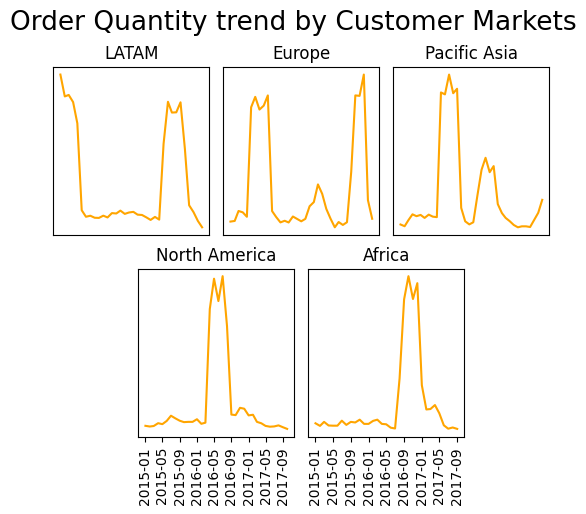

In [7]:

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

axes = [ax1, ax2, ax3, ax4, ax5]
labels = data["Customer Market"].unique()
for i in range(len(labels)):
    temp = data[data["Customer Market"] == labels[i]] 
    temp["Order Date"] = temp["Order Year"].astype(str) + "-" + temp["Order Month"].astype(str)
    temp["Order Date"] = pd.to_datetime(temp["Order Date"])
    orders_time = temp.groupby("Order Date")["Order Quantity"].sum()
    axes[i].plot(orders_time.index, orders_time.values, c = "orange")
    axes[i].set_title(labels[i])
    if i < 3:
        axes[i].get_xaxis().set_visible(False)
    else:
        axes[i].tick_params(axis='x', labelrotation = 90)
    axes[i].get_yaxis().set_visible(False)
plt.suptitle(y = 1, t = "Order Quantity trend by Customer Markets", size=19)
plt.show()

Customers in different markets make orders in different seasons that usually last from 3 to 5 months. 

-> By predicting the next season with high order quantity, we can optimize our supply chain by increase supply in these timeframe and keep less inventory in the warehouse in low seasons.

![image_2023-07-31_212436298](image_2023-07-31_212436298.png)


Despite most of the orders (57% of the total number of order items) came from the European and Latin American markets, these markets had the lowest on-time shipping rate.

## 2. Supply and demmand analysis

Taking a closer look at the most demanded products:

Text(0.5, 1.0, 'Average late shipment days on top 5 most demanded products')

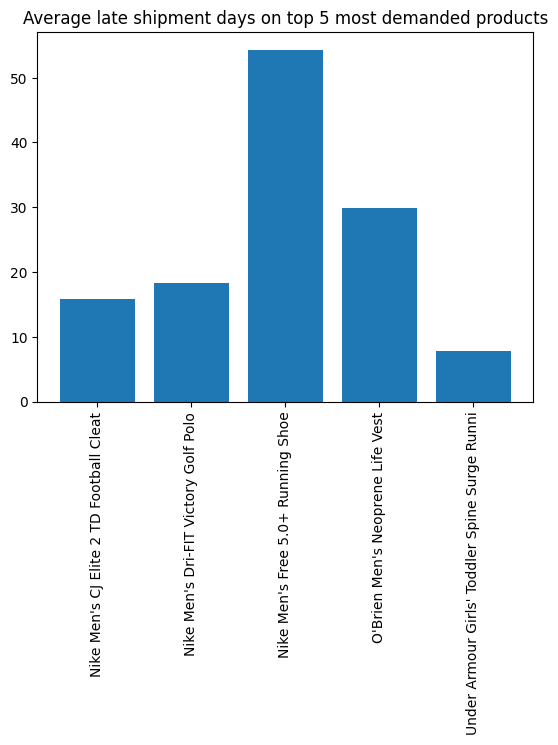

In [8]:
top_5_most_demanded = data.groupby("Product Name")["Order Quantity"].sum().sort_values(ascending = False)[1:6].index
temp = data[data["Product Name"].isin(top_5_most_demanded)]
avg_late_shipment_days = temp.groupby("Product Name")["Shipment Days - Late"].mean()
plt.bar(avg_late_shipment_days.index, avg_late_shipment_days.values)
plt.tick_params(axis='x', labelrotation = 90)
plt.title("Average late shipment days on top 5 most demanded products")

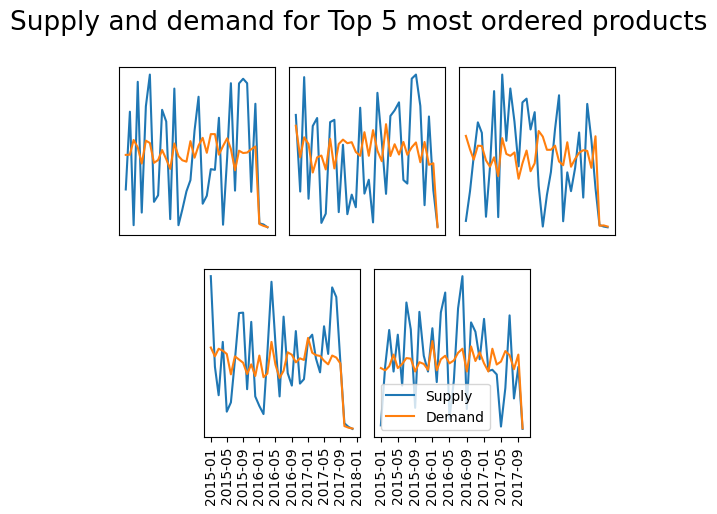

In [9]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

axes = [ax1, ax2, ax3, ax4, ax5]
labels = data["Customer Market"].unique()
for i in range(len(top_5_most_demanded)):
    temp = inventory[inventory["Product Name"] == top_5_most_demanded[i]]
    axes[i].plot(temp["Year Month"], temp["Warehouse Inventory"], label ="Supply")
    axes[i].plot(temp["Year Month"], temp["Order Quantity"], label = "Demand")
    if i < 3:
        axes[i].get_xaxis().set_visible(False)
    else:
        axes[i].tick_params(axis='x', labelrotation = 90)
    axes[i].get_yaxis().set_visible(False)
plt.suptitle(y = 1, t = "Supply and demand for Top 5 most ordered products", size=19)
ax5.legend()

Based on the data on Top 5 most ordered products, the orders can be 50 days late, which may contributed to the underwhelming 26% of customers returned to order more. One reason for this lateness is the inability to predict the demmand for the upcoming month as the supply vs demmand analysis show that the supply is either extremely overstocked leading to high inventory cost, or understocked leading to late shipment.

## 🧾 Executive summary
Based on the analyis, the supply chain can be improved by conducting research on the preference of the Latin American and European market, which is the most important markets in terms of profit and demmand. Secondly, demmand exhibits high evidence of seasonality when classified into different markets, therefore, knowing the next high-demmand season in the right market can save a significant amount of inventory cost. Finally, the current supply chain is not optimized as most of the time inventory is overstock or understock by a lot. \
\
The suggestion for Just In Time is to develop a forecast model on demmand. An approach to tackle this is to consider this as a time-series regression problem and produce a good estimation of the upcoming months' demmand and plan the supply accordingly

## 🌐 Upload your dashboard
For Tableau: paste the link to your Tableau Public dashboard here.

https://public.tableau.com/app/profile/ddk8035/viz/Book1_16876167133190/Dashboard3